In [1]:
# imports
import os
import cv2
import math
import uuid
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.datasets import DatasetFolder
import numpy as np
import pickle

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches
from torchsummary import summary

### Declarate Network

In [2]:
# declare your network-structure here
class FCNN(nn.Module):
    """
    This is a class for fully convolutional neural networks.
    
    It is a subclass of the Module class from torch.nn.
    See the torch.nn documentation for more information.
    """
    
    def __init__(self):
        """
        The constructor for FCNN class. The internal states of the network are initialized. 
        """
        
        super(FCNN, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, stride=1)
        self.conv2_drop = nn.Dropout2d()
        
        self.conv3 = nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=2)
        self.conv3_drop = nn.Dropout2d()
        
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, stride=1)
        
        self.conv5 = nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=120, out_channels=1, kernel_size=1, stride=1)
        
        
    def forward(self, data):
        """
        Defines the computation performed at every call.
        
        Parameters:
            data (torch.Tensor): The input that is evaluated by the network. 
                The network expects the input to be of 4 dimensions.
            
        Returns:
            x (torch.Tensor): The output of the network after evaluating it on the given input.
        """
        
        x = F.relu(self.conv0(data))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.relu(self.conv3_drop(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        return x

### Load trained Network..

In [3]:
ROOT = os.getcwd()

In [34]:
# run to load saved network parameters and training statistics
print("Load Network..")
local_network_name = 'TrainedNetworks/pollennet_oct.pt'

# declare blank network and load trained one
pollen_network = FCNN()
path_to_network = os.path.join(ROOT, local_network_name)
# initialise network with loaded parameters
pollen_network.load_state_dict(torch.load(path_to_network, map_location={'cuda:0': 'cpu'}))
pollen_network.eval()
# define criterion, optimizer and threshold
criterion = nn.MSELoss()
optimizer = optim.SGD(pollen_network.parameters(), lr=0.001, momentum=0.9)
threshold = 0.8
print("Network loaded.")

# load losses:
print("Load Trainingsdata..")
train_losses = pickle.load(open('TrainedNetworks/train_losses_oct.obj', 'rb'))
val_losses = pickle.load(open('TrainedNetworks/val_losses_oct.obj', 'rb'))
F1_scores = pickle.load(open('TrainedNetworks/F1_oct.obj', 'rb'))
accuracies = pickle.load(open('TrainedNetworks/accuracies_oct.obj', 'rb'))
print("Trainingdata loaded.")

Load Network..
Network loaded.
Load Trainingsdata..
Trainingdata loaded.


### Generate Samples

In [35]:
def non_max_suppression(heatmap, local_size = 8):
    pooling = nn.MaxPool2d((local_size * 2 - 1), stride = 1, padding = local_size - 1)
    max_filter = pooling(torch.tensor(heatmap)[None,...])
    max_filter = np.array(max_filter)
    heatmap = ((heatmap == max_filter) * (heatmap >= 0.8)).astype(int)
    heatmap_sup = heatmap[0,:,:]
    
    return heatmap_sup



def guess_pollen_coordinates(network, t_image):
    # takes an image and runs it thorugh the network to create a heatmap
    # apply non_max_suppresion on the heatmap and check for points of value 1 to determ the guessed coords
    coordinate_list = [] 
    h_coordinates = np.argwhere(non_max_suppression(np.array(torch.transpose(network(torch.transpose(t_image[...,None],1,3))[0,0,:,:],0,1))) == 1)
    for i in range(h_coordinates.shape[0]):
        coordinate_list.append((h_coordinates[i,1] * 2 * 2 * 2 + 28, h_coordinates[i,0] * 2 * 2 * 2 + 28))
    return coordinate_list



def add_guesses(samples, network):
    """
     Takes images of any size into the network and returns the corresponding heatmaps. 
    
    Parameters:
     network (FCNN): A fully convolutional neural network, that is used to compute a heatmap.
     samples:        list of tuples, each tuple contains an integer, a path to an image and coords of all real objects in given image
    
    Returns:
     guesses:        A list of tuples containing integer, img_path, coords of real and guessed objects
    """
    
    guesses = []
    
    print('Adding guessed coords...')
    
    with torch.no_grad():
        for f, orig_image_path, orig_coords in samples:
            img = cv2.imread(orig_image_path, cv2.IMREAD_GRAYSCALE)
            t_image = torch.Tensor(np.array(img))[None, ...]            
            guessed_coords = guess_pollen_coordinates(network, t_image)
            guesses.append((f, orig_image_path, orig_coords, guessed_coords))
    
    print('Guesses added.')
    return guesses



def get_samples(dir, network):
    """Takes a directory of images and a network to generate samples
        of given images. Each sample will contain an image, a none max suppression heatmap of the image,
        coords of existing objects and coords of objects found by the network
    
    Args:
        dir (String):   path to images with structure:
                        root/
                            img/
                                x.png
                                y.png
                                ..
                            ann/
                                x.png.json
                                y.png.json
                                ..
        
        network (FCNN): A fully convolutional neural network, that is used to compute a heatmap.
    
    Returns:
        samples:        list of tuples, each tuple contains:
                            a random generated foldername to assign images to each other (will be used to store images to generate videos)
                            a path to an sampleimage
                            coords of all real objects
                            coords of guessed objects
    """

    print("Create Samples..")
    samples = []
    print("Collect images..")
    for root, folders, files in os.walk(dir):
        for folder in folders:
            if folder == 'img':
                folder_name = str(uuid.uuid4())[:8]
                for img_root, img_folder, img_files in os.walk(os.path.join(root, folder)):
                    for img_file in img_files:
                        # for each image file go find its related annotation file:
                        found_ann = False
                        for ann_root, ann_folder, ann_files in os.walk(os.path.join(root, 'ann')):
                            if found_ann:
                                break
                            for ann_file in ann_files:
                                if img_file in ann_file:
                                    # found a pair!
                                    cur_coords = []
                                    with open(os.path.join(ann_root, ann_file)) as ann_json:
                                        ann_data = json.load(ann_json)
                                    cur_len = len(ann_data['objects'])
                                    if cur_len:
                                        for obj in ann_data['objects']:
                                            cur_coords.append(tuple(obj['points']['exterior'][0]))
                                    img_path = os.path.join(img_root, img_file)
                                    samples.append((folder_name, img_path, cur_coords))
                                    # to prevent unnecessary looping:
                                    found_ann = True
                                    break
    
    print("Images collected.")
    
    samples = add_guesses(samples, network)
    
    print("Samples created.")
    return samples

In [15]:
# Create Samples of Images
full_size_path = os.path.join(ROOT, 'Fullsize')
full_size_image_samples = get_samples(full_size_path, pollen_network)

Create Samples..
Collect images..
Images collected.
Adding guessed coords...
Guesses added.
Samples created.


## Evaluation

In [16]:
def b_eukl_dist(p, q, threshold):
    """Returns boolean whether distance between two points is smaller than threshold"""
    d = math.sqrt(((p[0]-q[0])**2)+((p[1]-q[1])**2))
    return (d <= threshold)



def verify_guesses(actual_positions, network_guesses, threshold):
    # threshold how far away a guess can be from an actuall object (centre to centre)
    object_found = {coord:False for coord in actual_positions}  # list of objects found by guesses (to get FN)
    confusion_matrix = [[], [], []]    # TP, FP, FN
    
    # check if guessed coords match with real ones
    for g_coord in network_guesses:
        correct_guess = False
        for r_coord in actual_positions:
            if b_eukl_dist(g_coord, r_coord, threshold):
                confusion_matrix[0].append(g_coord) # guess becomes TP
                object_found[r_coord] = True # object was found
                correct_guess = True
        if not correct_guess:
            confusion_matrix[1].append(g_coord) # guess becomes FP
    for key in object_found:
        if not object_found[key]:
            confusion_matrix[2].append(key)
    
    return confusion_matrix



def evaluation(samples, object_deviation):
    # samples           - list of tuples, [str, img_path, real_coords, guessed_coords, non_max_hmap]
    # object_deviatian  - distance bewteen a guess and a real pollen in which the guess is considered correct
    confusion_matrices = [] # 2D list. Consists of integer, img_path and corresponding TP, FP and FN [f, img_path, [TP], [FP], [FN]]
    for i, sample in enumerate(samples):
        confusion_matrices.append([sample[0]] + [sample[1]] + verify_guesses(sample[2], sample[3], object_deviation))
    
    sum_matrix = [0,0,0] # TP, FP, FN
    for matrix in confusion_matrices:
        sum_matrix[0] = sum_matrix[0] + len(matrix[2])
        sum_matrix[1] = sum_matrix[1] + len(matrix[3])
        sum_matrix[2] = sum_matrix[2] + len(matrix[4])
    
    precision = sum_matrix[0]/(sum_matrix[0] + sum_matrix[1])
    recall = sum_matrix[0]/(sum_matrix[0] + sum_matrix[2])
    
    return confusion_matrices, precision, recall

In [17]:
confusion_matrices, precision, recall = evaluation(full_size_image_samples,30)
print("Preision: ", precision)
print("Recall: ", recall)

Preision:  0.012452107279693486
Recall:  0.5652173913043478


## Visualisation

In [31]:
def get_vertices(coord, img_size, object_size):
    y = coord[1]
    if y == img_size[0]:
        y == img_size[0]-1
    x = coord[0]
    if x == img_size[1]:
        x == img_size[1]-1

    start_y = y - (object_size//2)
    if ( start_y < 0 ):
        start_y = 0
        border_top = (object_size//2)-y
    else:
        border_top = 0

    end_y = start_y + object_size - border_top
    if end_y > img_size[0]:
        border_bottom = end_y-img_size[0]
        end_y = img_size[0]
    else:
        border_bottom = 0

    start_x = x - (object_size//2)
    if ( start_x < 0 ):
        start_x = 0
        border_left = (object_size//2)-x
    else:
        border_left = 0

    end_x = start_x + object_size - border_left
    if end_x > img_size[1]:
        border_right = end_x-img_size[1]
        end_x = img_size[1]
    else:
        border_right = 0
    
    return start_y, end_y, start_x, end_x, border_top, border_bottom, border_left, border_right



def clip_around_coord(img, coord, img_size, object_size):
    # img                       - image opened with cv2
    # image_size (int,int)      - (img_height(y), img_width(x))
    # coord (int, int)          - (x,y)
    # object_size (int)         - px height (square) of clip
    
    start_y, end_y, start_x, end_x, border_top, border_bottom, border_left, border_right = get_vertices(coord, img_size, object_size)
    obj_example = img[start_y:end_y, start_x:end_x]
    obj_example = cv2.copyMakeBorder(obj_example, border_top, border_bottom, border_left, border_right, cv2.BORDER_REPLICATE)
    
    return obj_example



def get_filename(path):
    # extracts the filename of a given path (works for pathes with / or \ in it):
    # '/home/tkf/Desktop/dev/pollen-detection/example.jpg' -> 'example.jpg'
    # 'C:\home\tkf\Desktop\dev\pollen-detection\example.jpg' -> 'example.jpg'
    file_name = ""
    if path[-1] == '/' or path[-1] == "\\":
        path = path[:-1]
    while len(path) and path[-1] != '/' and path[-1] != '\\':
        file_name = path[-1] + file_name
        path = path[:-1]
    return file_name



def make_file(image, orig_name, folder):
    # image         - image that shall be saved
    # orig_name     - path to original image (extract orig name here, to keep the correct order)
    # folder        - integer to keep track of images that belong together
    file_name = get_filename(orig_name)
    root = os.getcwd()
    video_dir = os.path.join(root, 'VideoResults', folder)
    if os.path.isdir(video_dir):
        file_dir = os.path.join(video_dir, file_name)
        name_not_available = True
        while name_not_available:
            if os.path.isdir(file_dir):
                file_name = input("This File " + file_name + " already exists, please insert a new filename: ")
                file_dir = os.path.join(video_dir, file_name)
            else:
                name_not_available = False
                cv2.imwrite(file_dir, image)
    else:
        os.makedirs(video_dir)
        file_dir = os.path.join(video_dir, file_name)
        cv2.imwrite(file_dir, image)
        
    return



def visualise_cms(cms, network, object_size=64, max_examples=10, plotwidth=20, create_video=True, box_size=256):
    # will visualise guesses
    # for TP, FP, FN each we have a list (of length max_examples, if max_examples = 0, you will plot everything) of 2-tuples with coords and its predicted value by the network (we crop around a coord and run it through the network)
    # plots will be crops around coords in those three lists
    plots = [[],[],[]] # list of lists of TP, FP and FN, each item will be a tuple of a image section and its network prediction. First half of them will be the worst predictions, other half the best predictions
    titles = ['Correct Guesses (TP)', 'Wrong Guesses (FP)', 'Missed (FN)']
    colours = [(255,0,0),(0,0,255),(0,255,0)]
    video_folder_names = []
    # fill lists:
    # cm = [str, img_path, [TP], [FP], [FN] ]
    for cm in cms:
        if not cm[0] in video_folder_names:
            video_folder_names.append(cm[0])
        img = cv2.imread(cm[1],0)
        img_size = img.shape
        boxes = []  # contains: rectangle_start_pos, rectangle_end_pos, recangle_colour, rectangle_title
        for i in range(3):  # go through TP FP and FN
            for coord in cm[i+2]:
                obj_example = clip_around_coord(img, coord, img_size, object_size)  # get image section
                np_image = np.array(obj_example)    # prep to run through network
                t_image = torch.Tensor(np_image).unsqueeze(0)
                output = network(torch.transpose(t_image[...,None],1,3)).view(-1)  # get network predicted value for current image
                output = round(output.item(), 2)
                if max_examples == 0:   # will add all examples if told so by user
                    plots[i].append((obj_example, output))
                    plots[i].sort(key=lambda x:x[1])
                elif len(plots[i]) < max_examples:  # add no more than told by user
                    plots[i].append((obj_example, output))
                    plots[i].sort(key=lambda x:x[1])
                else:
                    if output > plots[i][max_examples//2:][-1][1]: # check whether its worse than the best of the worst predictions
                        plots[i][max_examples//2:][-1] = (obj_example, output)
                        plots[i].sort(key=lambda x:x[1])
                    elif plots[i][:max_examples//2][-1][1] < output:  # or better than the worst of the best predictions
                        plots[i][:max_examples//2][-1] = (obj_example, output)
                
                if create_video: # add rectangles to images
                    y0, y1, x0, x1, bt, bb, bl, br = get_vertices(coord, img_size, box_size)
                    boxes.append(((x0,y0),(x1,y1),colours[i], output))
        
        # save image
        if create_video:
            img = cv2.imread(cm[1])
            for box in boxes:
                cv2.rectangle(img, box[0], box[1], box[2], 3)
                position = (box[0][0]+20, box[0][1]+20)
                cv2.putText(img=img, text=str(box[3]), org=position, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=box[2], thickness=2)
            make_file(img, cm[1], cm[0])
    
    
    # plot lists:
    for j, plot in enumerate(plots):
        obj_counter = 0
        # set up figure
        if max_examples < 8:
            columns = max_examples
        else:
            columns = 6
        rows = math.ceil(len(plot)/columns)
        fig = plt.figure(figsize=(3*columns,(rows*2)+4), constrained_layout=True)
        fig.suptitle(titles[j], size=20)
        gs = gridspec.GridSpec(nrows=rows, ncols=columns, figure=fig, hspace=20)
        for row in range(rows):
            for column in range(columns):
                if obj_counter < len(plot):
                    ax = fig.add_subplot(gs[row, column], title=plot[obj_counter][1])
                    ax.imshow(plot[obj_counter][0], cmap='gray')
                    obj_counter += 1
        plt.show
    
    
    if create_video:
        # create videos
        root = os.getcwd()
        for folder in video_folder_names:
            folder_dir = os.path.join(root, 'VideoResults', folder)
            video_name = os.path.join(root, 'VideoResults', folder, 'results.avi')
            video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 2, (img_size[1], img_size[0]))
            for frame in sorted(os.listdir(folder_dir)):
                frame_dir = os.path.join(folder_dir, frame)
                video.write(cv2.imread(frame_dir))
            video.release()
                
    

### Visualise training

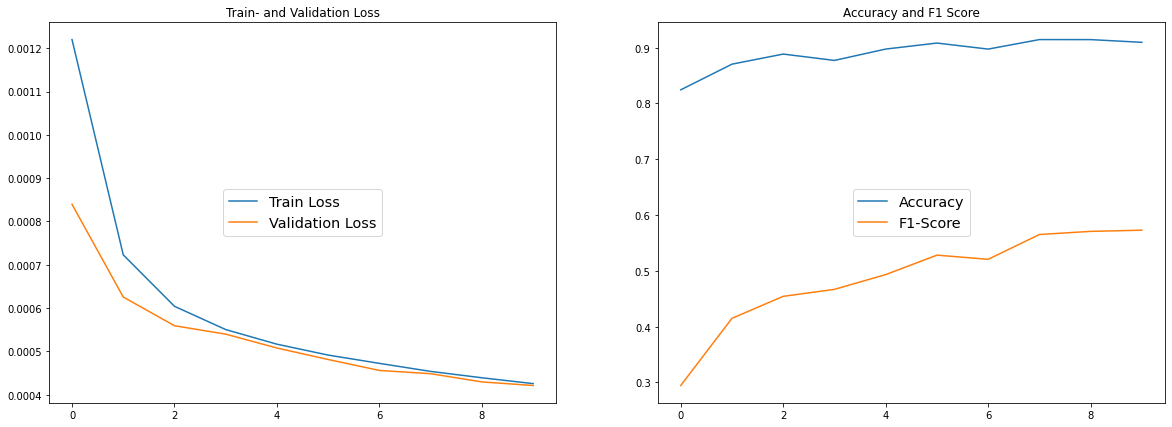

In [19]:
# plot losses and accuracies
fig_loss, ax_loss = plt.subplots(1,2)
fig_loss.set_size_inches(20,7)
ax_loss[0].set_title("Train- and Validation Loss")
ax_loss[0].plot(train_losses, label='Train Loss')
ax_loss[0].plot(val_losses, label='Validation Loss')
ax_loss[1].set_title("Accuracy and F1 Score")
ax_loss[1].plot(accuracies, label='Accuracy')
ax_loss[1].plot(F1_scores, label='F1-Score')

legend0 = ax_loss[0].legend(loc='center', fontsize='x-large')
legend1 = ax_loss[1].legend(loc='center', fontsize='x-large')

plt.show()

### Visualise Accuracy

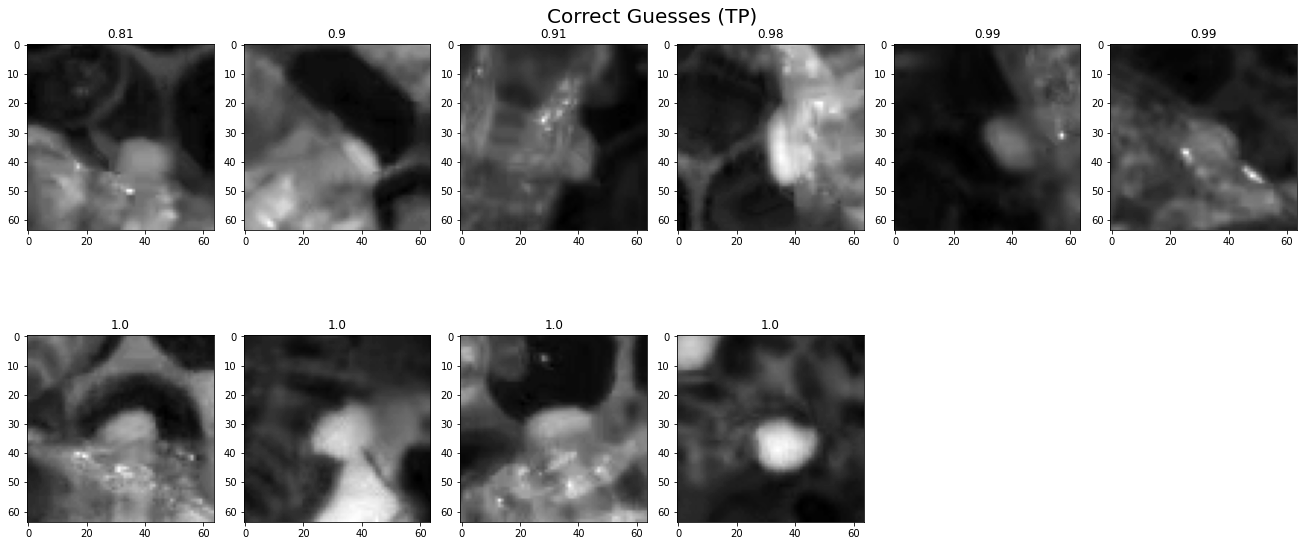

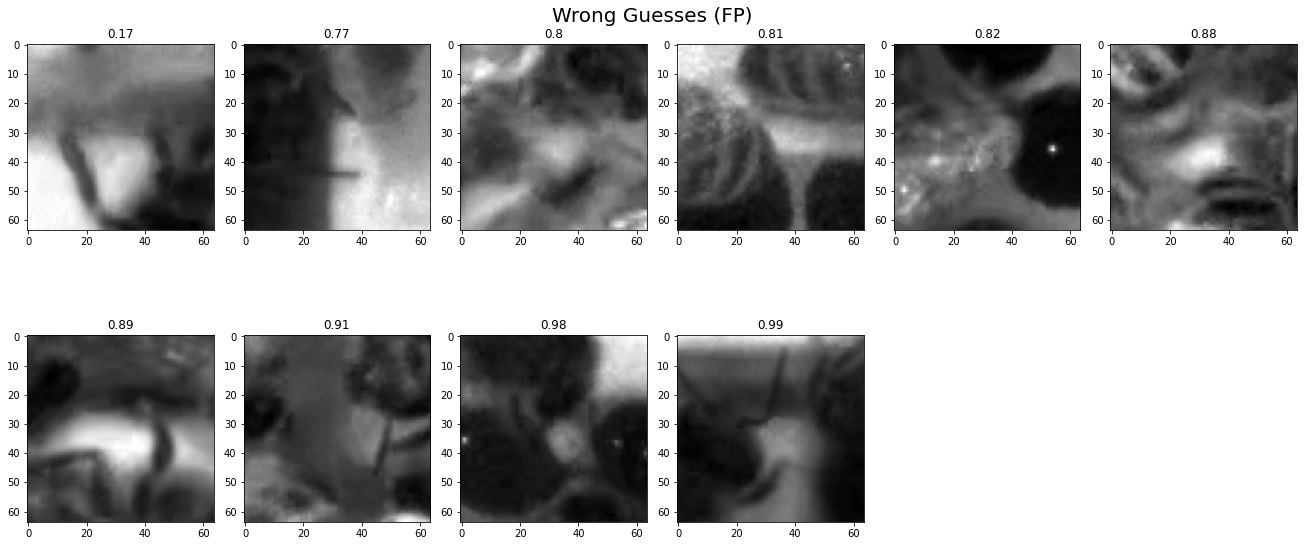

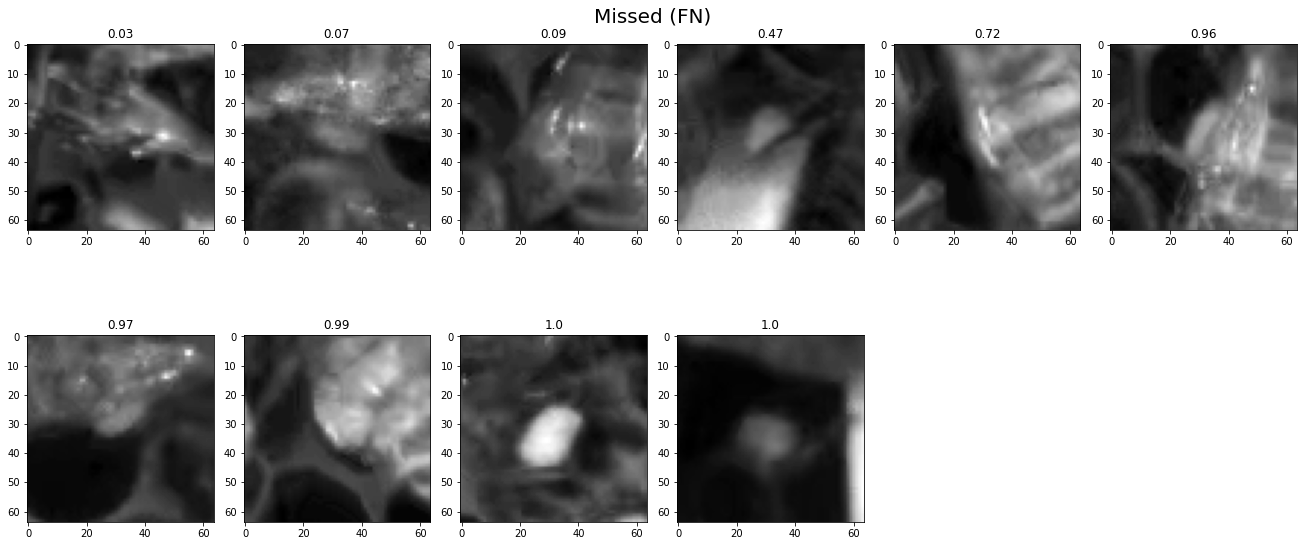

In [32]:
visualise_cms(confusion_matrices, pollen_network, 64, 10, 20, True, 128)